## Modelling
Run the linear regression and decision tree, and analyse

In [17]:
# import all constants used in the note books
from constants import *

# libraries required

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import scipy.stats

from pyspark.sql import DataFrame

from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

from matplotlib.dates import DateFormatter

In [2]:
# Create a spark session 
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/08/21 08:01:25 WARN Utils: Your hostname, DESKTOP-VP2PCTV resolves to a loopback address: 127.0.1.1; using 172.21.252.215 instead (on interface eth0)
23/08/21 08:01:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/21 08:01:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Linear Regression
### One Hot Encoding
The categorical variables need to be one-hot encoded to run the linear regression

In [5]:
# read the train and test data
train_data = spark.read.parquet(ANALYSIS_DATA+'train_data')
test_data = spark.read.parquet(ANALYSIS_DATA+'test_data')

# Create an instance of the one hot encoder - required for linear regression on categorical variables
onehot = OneHotEncoder(inputCols=['pickup_id', 'month', 'hour'], outputCols=['pickup_dummy','month_dummy', 'hour_dummy'])

# Apply the one hot encoder to the data
onehot = onehot.fit(train_data)
train_data_onehot = onehot.transform(train_data)
test_data_onehot = onehot.transform(test_data)

## Linear Regression

In [9]:
def pyspark_lm(data: DataFrame, input_cols: list[str]) -> object:    
    '''
    Runs a pyspark ml linear regression
    Arguments:
        data = data to run regression over
        input_cols = columns to use for the regression        
    Ouput: a linear regression object
    '''
    
    # need to vectorise the features
    features = 'features'    
    assembler = VectorAssembler(
        # which column to combine
        inputCols=input_cols, 
        # How should the combined columns be named
        outputCol=features
    )
    model_sdf = assembler.transform(data.dropna('any'))
    
    # run the regression
    lm = LinearRegression(
        featuresCol='features', 
        labelCol='total_revenue',
        solver='normal',
        regParam = 0.0, elasticNetParam=0.0
    ).fit(model_sdf)

    return lm

# run the regression on the full model
full_model_cols = ['pickup_dummy', 'month_dummy', 'is_weekend', 'hour_dummy', 'ed_event', 'tmpc', 'sped', 'p01m', 'revenue_lag']
full_model = pyspark_lm(train_data_onehot, full_model_cols)   

23/08/21 08:05:39 WARN Instrumentation: [51fc4a52] regParam is zero, which might cause numerical instability and overfitting.
23/08/21 08:05:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/21 08:05:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/08/21 08:05:45 WARN Instrumentation: [51fc4a52] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


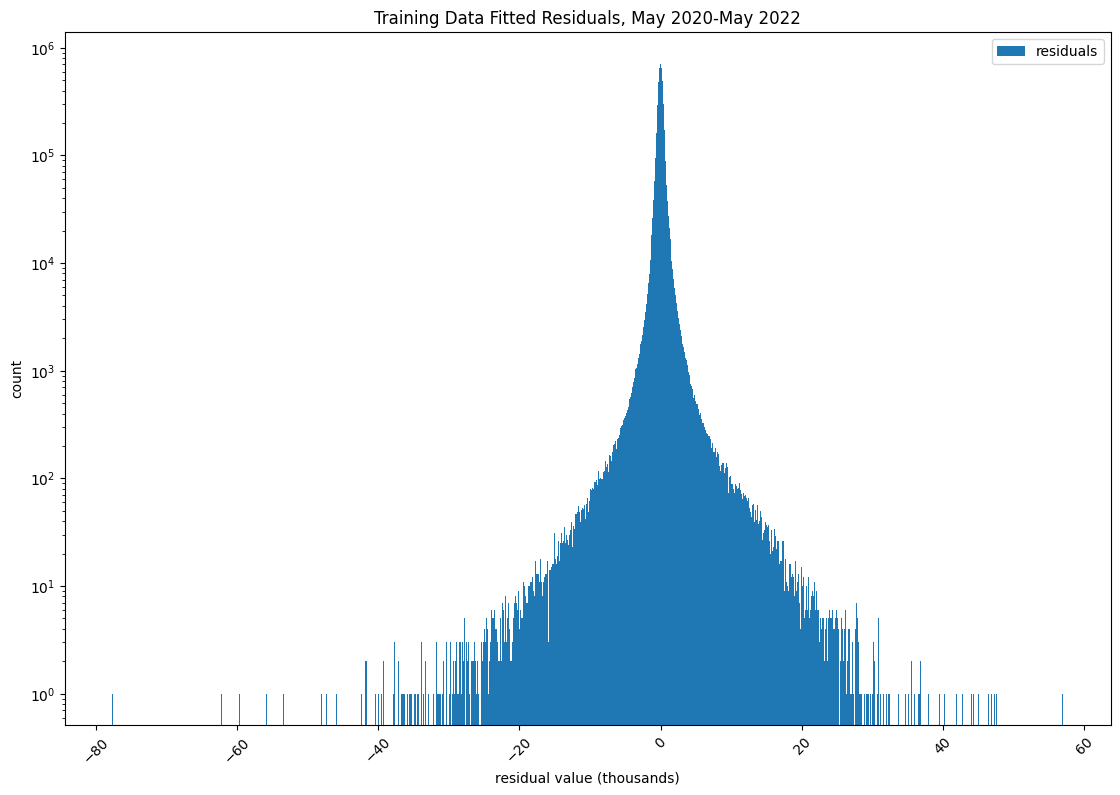

In [10]:
# plot the residuals 
all_residuals = (full_model.summary.residuals).toPandas()
all_residuals = all_residuals/1000

plot = all_residuals.plot.hist(
    title = 'Training Data Fitted Residuals, May 2020-May 2022', 
    ylabel='count',
    log=True,
    bins=1000,rot = 45)

plot.set_xlabel("residual value (thousands)")
fig = plot.get_figure()
fig.set_size_inches(13.5, 9)

fig.savefig(f'{PLOTS}residuals_dist.jpg', bbox_inches='tight')

In [11]:
def pyspark_predict(lm: object, data: DataFrame, input_cols: list[str]) -> object:    
    '''
    Generates predictions for a provided linear regression, on a test data set
    Arguments:
        lm = a pyspark linear regression object
        data = data to run predictions over (a test set)
        input_cols = columns to use for the prediction
    Ouput: a predictions object
    '''
    
    # need to vectorise the features
    features = 'features'        
    assembler = VectorAssembler(
        # which column to combine
        inputCols=input_cols, 
        # How should the combined columns be named
        outputCol=features
    )
    model_sdf = assembler.transform(data.dropna('any'))
    
    # run the predictions
    predictions = lm.transform(model_sdf)

    return predictions


def run_predictions(full_model: object, test_data: DataFrame, train_data: DataFrame, \
    full_model_cols: list[str], reduced_models: list[str,list[str]]) -> pd.DataFrame:
    '''    
    Generates predictions for a series of models, to compare against the full model. 
    Each new model should be a subset of the full model. Comparison is generated by way
    of RMSE and R^2
    Arguments:
        full_model = a pyspark linear regression object
        test_data = data to run predictions over (a test set)
        train_data = data to run regression over (a train set)
        full_model_cols = columns used for the full_model predictions
        reduced_models = columns used for the training and prediction of each of the reduced models
    Ouput: a table comparing rmse and R^2 between full model and reduced models
    '''
    
    # set up model evaluators
    evaluator = RegressionEvaluator(labelCol="total_revenue", predictionCol="prediction", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol="total_revenue", predictionCol="prediction", metricName="r2")

    # predictions for full model
    predictions = pyspark_predict(full_model, test_data, full_model_cols)
    rmse = [evaluator.evaluate(predictions)]
    r2 = [evaluator_r2.evaluate(predictions)]
    var_name = ['full']
    
    # run each reduced model one by one
    for model in reduced_models:
        print(f'running {model[0]}')
        var_name.append(model[0])
        reduced_model = pyspark_lm(train_data, model[1])
        predictions = pyspark_predict(reduced_model, test_data, model[1])
        rmse.append(evaluator.evaluate(predictions))
        r2.append(evaluator_r2.evaluate(predictions))

    results_table = pd.DataFrame(list(zip(var_name, rmse, r2)), columns=['variable', 'RMSE', 'R^2'])

    return(results_table)

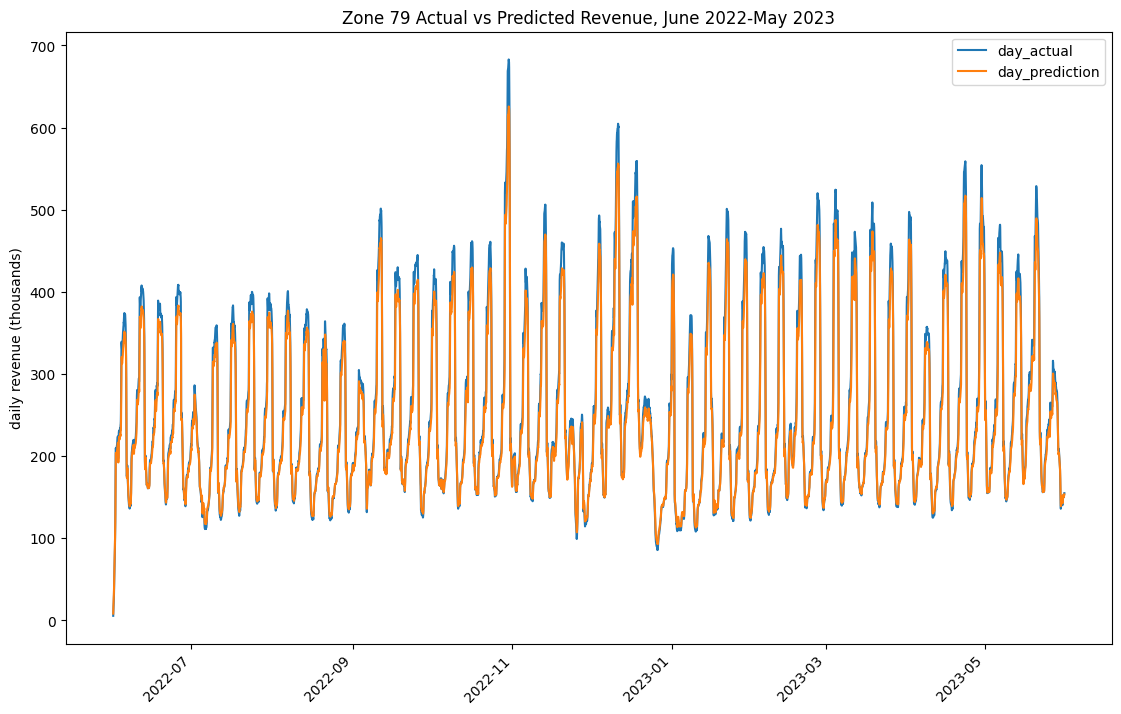

In [12]:
# take a close look at one pickup location to compare prediction with actual
# take zone 79 as that one of the top 10 revenue generating zones, which had a large
# number of outliers

# retrieve predictions for the full model on the test set, and extract zone 79
predictions = pyspark_predict(full_model, test_data_onehot, full_model_cols)
zone79_predictions = predictions.where(
    (F.col('pickup_id')==79)
).orderBy(['year','month','day','hour'])
zone79_predictions = zone79_predictions.select('date', 'hour', 'total_revenue', 'prediction').toPandas()
zone79_predictions['datetime'] = pd.to_datetime(zone79_predictions.date) + \
    pd.to_timedelta(zone79_predictions.hour, unit='h')

# generate a rollign 24 hour revenue series
zone79_predictions['day_actual'] =  zone79_predictions['total_revenue'].rolling(24, min_periods=1).sum()/1000
zone79_predictions['day_prediction'] =  zone79_predictions['prediction'].rolling(24, min_periods=1).sum()/1000

plot = zone79_predictions.plot.line(
    x='datetime', y=['day_actual', 'day_prediction'],
    title = 'Zone 79 Actual vs Predicted Revenue, June 2022-May 2023', 
    ylabel='daily revenue (thousands)',
    rot = 45)
ax = plot.get_xaxis()
ax.get_label().set_visible(False)
fig = plot.get_figure()
fig.set_size_inches(13.5, 9)

fig.savefig(f'{PLOTS}zone79.jpg', bbox_inches='tight')

In [14]:

def run_ANOVA(full_model: object, data: DataFrame, reduced_models: list[str,list[str]]) -> pd.DataFrame:
    '''
    Generates a "pseduo" ANOVA table. This is a table where each reduced model has had one or more
    features removed, to facilitate comparison against the full model. The canonical F statistic
    and F test is then applied to examine significance
    Arguments:
        full_model = a pyspark linear regression object
        data = data to run regressions over (a train set)
        reduced_models = columns used for the training of each of the reduced models
    Ouput: a table showing SSR, degrees freedom, F statistic, and F test for each of the reduced models
    '''
    # get number of observations
    num_obs = train_data.count()
    
    # get relevant statistic from the full model
    full_model_num_params = len(full_model.coefficients)
    full_model_MSE = full_model.summary.meanSquaredError
    full_model_SSR = full_model_MSE * num_obs

    # prepare the results data
    var_name = ['full']
    ss = [full_model_SSR]
    df = [full_model_num_params]
    F = [0]
    Pr = [0]
    
    # run each reduced model one by one
    for model in reduced_models:
        print(f'running {model[0]}')
        var_name.append(model[0])
        
        # run the  regression and get the relevant statistics
        reduced_model = pyspark_lm(data, model[1])
        reduced_model_num_params = len(reduced_model.coefficients)
        reduced_model_MSE = reduced_model.summary.meanSquaredError
        reduced_model_SSR = reduced_model_MSE * num_obs

        # degrees of freedom for the F statistic
        df_numerator = full_model_num_params-reduced_model_num_params
        df_denominator = num_obs-full_model_num_params

        # calculate the F statistic
        F_stat = ((reduced_model_SSR - full_model_SSR)/(df_numerator)) / \
            (full_model_SSR/(df_denominator))

        ss.append(reduced_model_SSR)
        df.append(reduced_model_num_params)
        F.append(F_stat)
        Pr.append(scipy.stats.f.sf(F_stat, dfn=df_numerator, dfd=df_denominator))

    results_table = pd.DataFrame(list(zip(var_name, ss, df, F, Pr)), columns=['variable', 'sum_squares', 'df', 'F_stat', 'Pr(>F)'])

    return(results_table)

In [15]:
# the reduced models remove one variable at a time. Note that hour and location ID are not tested
# as the other variables make no sense with these removed
reduced_models = [
    ['event', ['pickup_dummy', 'month_dummy', 'is_weekend', 'hour_dummy', 'tmpc', 'sped', 'p01m', 'revenue_lag']],
    ['weather', ['pickup_dummy', 'month_dummy', 'is_weekend', 'hour_dummy', 'ed_event', 'revenue_lag']],
    ['lag', ['pickup_dummy', 'month_dummy', 'is_weekend', 'hour_dummy', 'ed_event', 'tmpc', 'sped', 'p01m']],
    ['month', ['pickup_dummy', 'is_weekend', 'hour_dummy', 'ed_event', 'tmpc', 'sped', 'p01m', 'revenue_lag']],
    ['weekend', ['pickup_dummy', 'month_dummy', 'hour_dummy', 'ed_event', 'tmpc', 'sped', 'p01m', 'revenue_lag']]
]

results_table = run_ANOVA(full_model, train_data_onehot, reduced_models)
results_table.to_csv(ANALYSIS_DATA+'results_table.csv')

running event


23/08/21 08:19:56 WARN Instrumentation: [3d0d6abd] regParam is zero, which might cause numerical instability and overfitting.
23/08/21 08:20:00 WARN Instrumentation: [3d0d6abd] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/08/21 08:20:05 WARN Instrumentation: [473f82c5] regParam is zero, which might cause numerical instability and overfitting.


running weather


23/08/21 08:20:09 WARN Instrumentation: [473f82c5] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/08/21 08:20:14 WARN Instrumentation: [a7b92c98] regParam is zero, which might cause numerical instability and overfitting.


running lag


23/08/21 08:20:18 WARN Instrumentation: [a7b92c98] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/08/21 08:20:23 WARN Instrumentation: [1f5ef8e9] regParam is zero, which might cause numerical instability and overfitting.


running month


23/08/21 08:20:27 WARN Instrumentation: [1f5ef8e9] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/08/21 08:20:32 WARN Instrumentation: [5d3a2206] regParam is zero, which might cause numerical instability and overfitting.


running weekend


23/08/21 08:20:36 WARN Instrumentation: [5d3a2206] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [16]:
# run a comparison of all the reduced models on the test data, in terms of 
# RMSE and R^2 of the predictions

full_model_cols = ['pickup_dummy', 'month_dummy', 'is_weekend', 'hour_dummy', 'ed_event', 'tmpc', 'sped', 'p01m', 'revenue_lag']
predict_table = run_predictions(full_model, test_data_onehot, train_data_onehot, full_model_cols, reduced_models)
predict_table.to_csv(ANALYSIS_DATA+'predict_table.csv')

running event


23/08/21 08:21:30 WARN Instrumentation: [098c079a] regParam is zero, which might cause numerical instability and overfitting.
23/08/21 08:21:35 WARN Instrumentation: [098c079a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


running weather


23/08/21 08:21:43 WARN Instrumentation: [13f6ca8d] regParam is zero, which might cause numerical instability and overfitting.
23/08/21 08:21:48 WARN Instrumentation: [13f6ca8d] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


running lag


23/08/21 08:21:56 WARN Instrumentation: [c5314d9a] regParam is zero, which might cause numerical instability and overfitting.
23/08/21 08:22:01 WARN Instrumentation: [c5314d9a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


running month


23/08/21 08:22:10 WARN Instrumentation: [504015cb] regParam is zero, which might cause numerical instability and overfitting.
23/08/21 08:22:14 WARN Instrumentation: [504015cb] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
23/08/21 08:22:22 WARN Instrumentation: [17ff4219] regParam is zero, which might cause numerical instability and overfitting.


running weekend


23/08/21 08:22:27 WARN Instrumentation: [17ff4219] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


## Decision Tree

In [18]:
# run the decision tree on the full model
full_model_cols = ['pickup_id', 'month', 'is_weekend', 'hour', 'ed_event', 'tmpc', 'sped', 'p01m', 'revenue_lag']

# vectorise the features
features = 'features'    
assembler = VectorAssembler(
    # which column to combine
    inputCols=full_model_cols, 
    # How should the combined columns be named
    outputCol=features
)
model_sdf = assembler.transform(train_data.dropna('any'))

# automatically identify categorical features, and index them.
# specify maxCategories so features with > 4 distinct values are treated as continuous so 
# the the model runs efficiently. However note the max bin size of 300 facilitates
# "re-categorisation" of the data when the tree is run
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(model_sdf)

# train a DecisionTree model.
dt = DecisionTreeRegressor(labelCol="total_revenue", featuresCol="indexedFeatures", maxBins=300)

# chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dt])

# run the model and indexer
model = pipeline.fit(model_sdf)

# check performance on the test_data, note no need to use one hot encoded data
test_sdf = assembler.transform(test_data.dropna('any'))
predictions = model.transform(test_sdf)

# check the model fit
evaluator = RegressionEvaluator(
    labelCol="total_revenue", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

evaluator = RegressionEvaluator(
    labelCol="total_revenue", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)

print ("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print ("R^2 on test data = %g" % r2)

treeModel = model.stages[1]
print (treeModel) # summary only

Root Mean Squared Error (RMSE) on test data = 1974.89
R^2 on test data = 0.830682
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_474fdd648099, depth=5, numNodes=63, numFeatures=9
